In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

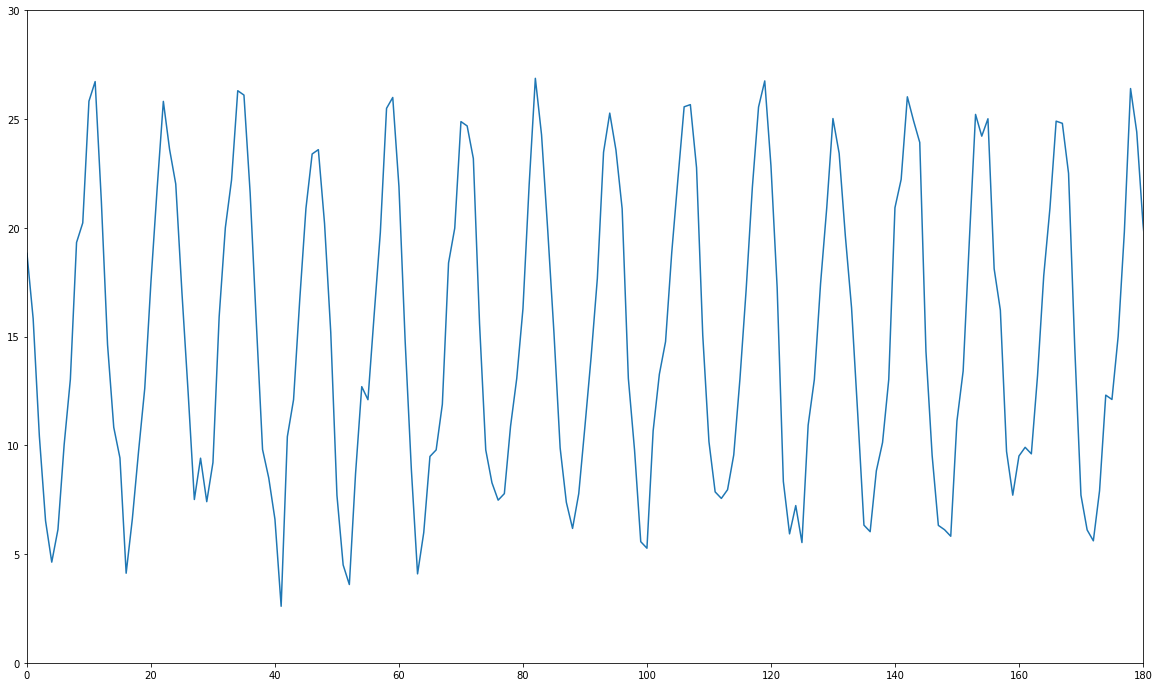

In [3]:
dataframe = pandas.read_csv('data/station.csv', usecols=[1,2,3,4,5,6,7,8,9,10,11,12], engine='python', skiprows=0)
# Map sentinels to a sensible value
dataframe = dataframe.replace(999.90, 7)
# Reshape to sequence of monthly temperatures
dataset = dataframe.values.reshape(np.prod(dataframe.shape), 1)
# Remove first 8 values (sentinels)
dataset = dataset[8:] 

# Plot 20 years
plt.rcParams['figure.figsize'] = (20.0, 12.0)
plt.plot(dataset)
plt.axis([0,15 * 12,0,30])
plt.show()

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX = [dataset[i:i+look_back] for i in range(0, len(dataset) - look_back)]
    dataY = [dataset[i] for i in range(look_back, len(dataset))]
    return np.array(dataX), np.array(dataY)

In [6]:
# reshape into X=t and Y=t+1
look_back = 6
validation_split = 0.3
X,Y = create_dataset(dataset, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41.0
Trainable params: 41
Non-trainable params: 0.0
_________________________________________________________________


In [7]:
train_size = int(len(X) * (1 - validation_split))
test_size = len(X) - train_size
[trainX, testX] = np.array_split(X, [train_size])
[trainY, testY] = np.array_split(Y, [train_size])

In [8]:
# create and fit the network
model = Sequential()
model.add(Dense(5, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41.0
Trainable params: 41
Non-trainable params: 0.0
_________________________________________________________________


In [9]:
batch_size = 1
epochs = 10
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, shuffle=False, verbose=2)

Train on 527 samples, validate on 227 samples
Epoch 1/10


1s - loss: 0.0506 - val_loss: 0.0320
Epoch 2/10


0s - loss: 0.0200 - val_loss: 0.0131
Epoch 3/10


0s - loss: 0.0095 - val_loss: 0.0065
Epoch 4/10


0s - loss: 0.0060 - val_loss: 0.0047
Epoch 5/10


0s - loss: 0.0052 - val_loss: 0.0042
Epoch 6/10


0s - loss: 0.0049 - val_loss: 0.0041
Epoch 7/10


0s - loss: 0.0048 - val_loss: 0.0041
Epoch 8/10


1s - loss: 0.0047 - val_loss: 0.0041
Epoch 9/10


0s - loss: 0.0047 - val_loss: 0.0042
Epoch 10/10


0s - loss: 0.0046 - val_loss: 0.0042


In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict_t = scaler.inverse_transform(trainPredict)
trainY_t = scaler.inverse_transform(trainY)
testPredict_t = scaler.inverse_transform(testPredict)
testY_t = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_t, trainPredict_t[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_t, testPredict_t[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.14 RMSE
Test Score: 1.78 RMSE


In [11]:
from collections import deque
futurePredictions = []
lastPrediction = testPredict[0]
# print('Last prediction: ')
# print(lastPrediction)
futurePredictions.append(lastPrediction)
# print('Future predictions: ')
# print(futurePredictions)
# print('Last training X:')
# print(trainX[-1])
dq = deque(testX[0].copy())
futureXs = []

for i in range(testY_t.size - 1):
    dq.popleft()
    dq.append(lastPrediction)
    futureX = np.reshape(dq, (1, look_back))
    futureXs = np.reshape(np.append(futureXs, futureX), (i + 1, look_back))
    lastPrediction = model.predict(futureXs)[-1][0]
    futurePredictions.append(lastPrediction)
    # print('Last prediction: ')
    # print(lastPrediction)
    # print('Future predictions: ')
    # print(futurePredictions)

futurePredict_t = scaler.inverse_transform([futurePredictions])
futurePredict_t = np.reshape(futurePredict_t, testPredict_t.shape)
# print(testPredict_t)
# print(futurePredict_t)
# print(np.hstack((np.reshape(testY_t, testPredict_t.shape), testPredict_t, futurePredict_t)))
futScore = math.sqrt(mean_squared_error(testY_t[0], futurePredict_t[0]))
print('Future Score: %.2f RMSE' % (futScore))

Future Score: 0.73 RMSE


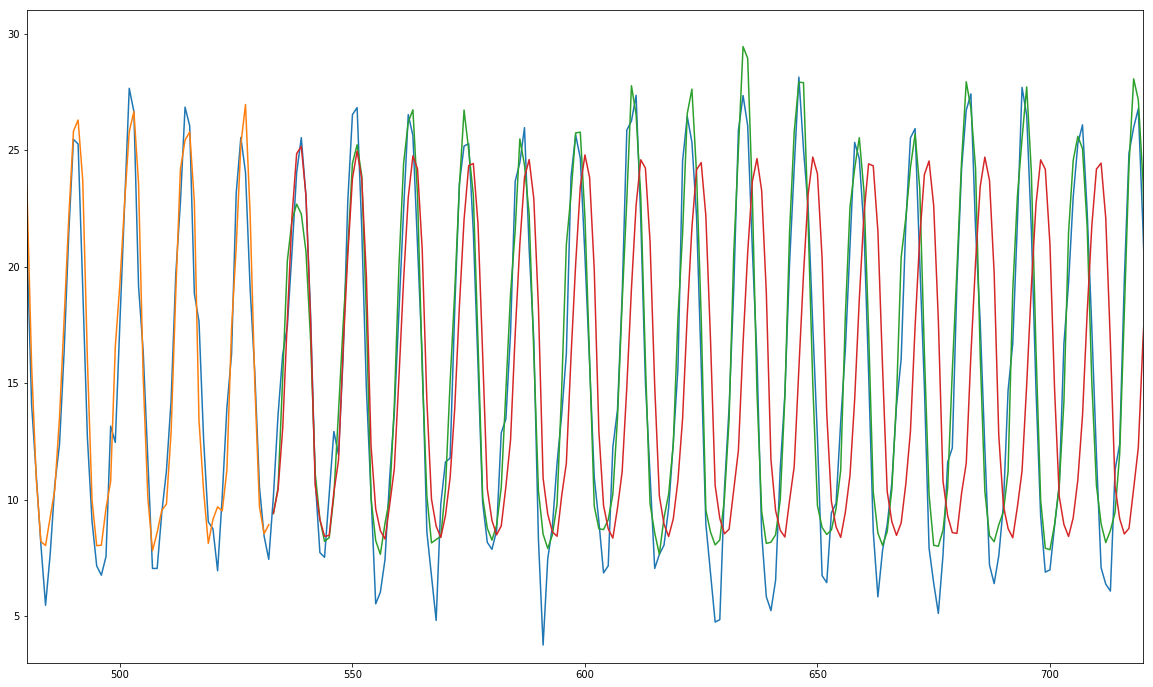

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_t)+look_back, :] = trainPredict_t
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict_t):, :] = testPredict_t
# shift future predictions for plotting
futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot[-len(futurePredict_t):, :] = futurePredict_t

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(futurePredictPlot)
start_year = 40
years = 20
plt.axis([start_year * 12,(start_year + years) * 12,3,31])
plt.show()

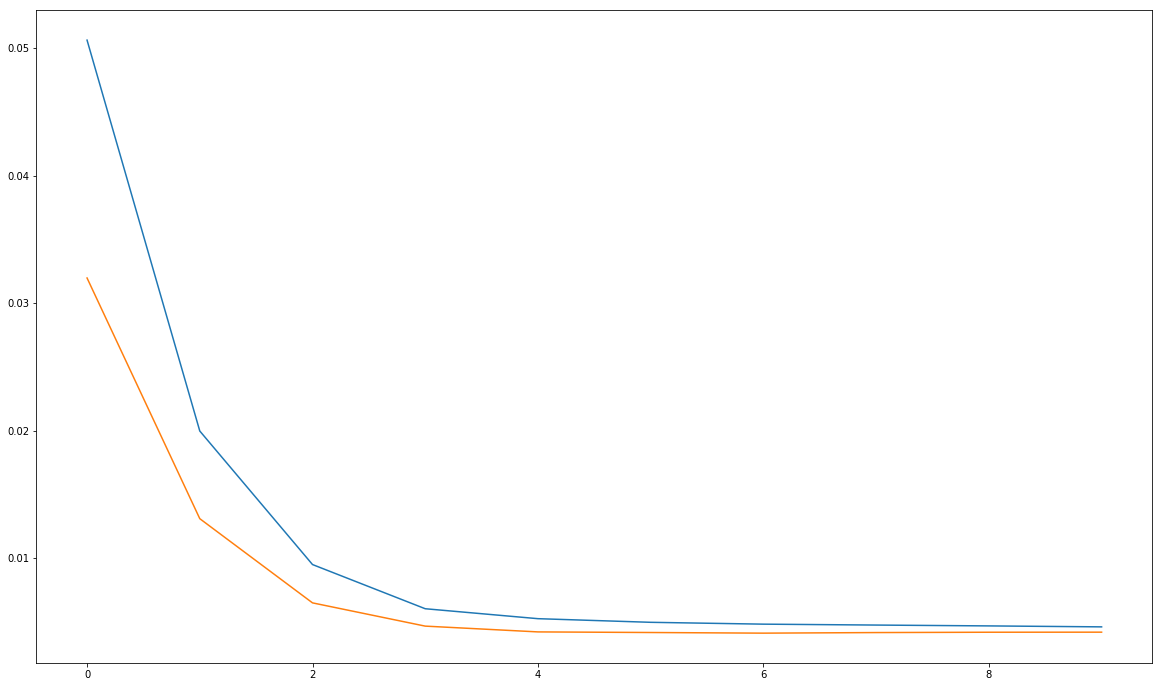

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [15]:
model.get_weights()

[array([[ 0.147811  ,  0.26369873, -0.46941936, -0.051853  ,  0.16776031],
        [-0.41163686, -0.7492733 , -0.26556903, -0.54565901, -0.67209107],
        [-0.38303527, -0.54303807,  0.04879263, -0.51870394,  0.0080388 ],
        [ 0.38012797,  0.03966361, -0.29534867, -0.51306254,  0.0498862 ],
        [ 0.03603538, -0.13552596,  0.14551142, -0.23624545,  0.05331738],
        [ 0.22978999, -0.02186378,  0.54448152,  0.14273757,  0.17359397]], dtype=float32),
 array([ 0.29002529, -0.0143439 ,  0.20407464,  0.        , -0.06194525], dtype=float32),
 array([[ 0.4576849 ],
        [-0.01654213],
        [ 1.00284517],
        [-0.66951919],
        [-0.39707753]], dtype=float32),
 array([ 0.18313874], dtype=float32)]